# Mask R-CNN Instance Segmentation

In the previous notebooks, we performed object detection, where bounding boxes were used to indicate the objects contained in an image.  In this notebook, we will introduce [Mask R-CNN](https://arxiv.org/abs/1703.06870) for instance segmentation.  In other words, we will get the contours or masks of objects in an image besides bounding boxes.

## Image Segmentation

Image segmentation categorises pixels in an image into different groups in terms of some criteria, such as semantic segmentation, instance segmentation and instance segmentation.  In this notebook, we are interested in instance segmentation which will not only detect the known objects in an image with bounding boxes, but also find which pixels belong to the objects using masks.

![Segmentation Comparison](media/segmentaion_comparison.png)

## Mask R-CNN

[Mask R-CNN](https://arxiv.org/abs/1703.06870) is an instance segmentation alrogithm based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497) and adds an extra branch for predicting segmentation masks for objects (instances).  That is, the same feature map for training the RPN (Region Proposal Network) and classifier in Faster R-CNN is also used in Mask R-CNN by a FCN (Fully Convolutional Network) to predict a binary mask for the object inside a bounding box.

![Mask R-CNN Framework](media/mask-r-cnn-framework.png)

## Initialization

In [1]:
# ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# imports
import numpy as np
import scrapbook as sb
import time

from pathlib import Path
from PIL import Image

# torch
import torch

# utility
import sys
sys.path.append("../../")

from utils_cv.common.data import unzip_url, get_files_in_directory
from utils_cv.common.gpu import which_processor
from utils_cv.common.plot import show_ims
from utils_cv.detection.bbox import AnnotationBbox
from utils_cv.detection.data import Urls
from utils_cv.detection.dataset import DetectionDataset, parse_pascal_voc_anno
from utils_cv.detection.mask import merge_binary_masks
from utils_cv.detection.model import DetectionLearner, get_pretrained_maskrcnn, get_pretrained_keypointrcnn
from utils_cv.detection.plot import display_bbox_mask, display_bbox_mask_keypoint, plot_boxes

# variables
device = torch.device('cpu')

which_processor()

Torch is using GPU: Quadro P400


## Browse the Dataset

We are going to use the [odFridgeObjects-mask datasets](https://github.com/simonzhaoms/testdata/raw/master/odFridgeObjects-mask.zip) for illustration.  This dataset includes 128 images of 4 class labels: `can`, `carton`, `milk_bottle` and `water_bottle`.

```
odFridgeObjects-mask/
├── annotations
│   ├── 1.xml
│   ├── 2.xml
│   ├── ...
│   ├── 127.xml
│   └── 128.xml
├── images
│   ├── 1.jpg
│   ├── 2.jpg
│   ├── ...
│   ├── 127.jpg
│   └── 128.jpg
└── segmentation-objects
    ├── 1.png
    ├── 2.png
    ├── ...
    ├── 127.png
    └── 128.png
```

In [3]:
# download odFridgeObjects-mask dataset
DATA_PATH = Path(unzip_url(Urls.fridge_objects_mask_path, exist_ok=True))

The `images` and `segmentation-objects` directory contain original images and their corresponding masks.  The annotations in the `annotations` directory are of format [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/).

In [4]:
# list of the paths of images, masks and annotations,
# sorting them to ensure that they are aligned
subdirs = ['images', 'segmentation-objects', 'annotations']
subdir_paths = [DATA_PATH / s for s in subdirs]
img_list, mask_list, annotation_list = (
    get_files_in_directory(p) for p in subdir_paths
)

# the first image, mask and annotation
img_path, mask_path, annotation_path = map(
    lambda x: x[0], 
    (img_list, mask_list, annotation_list)
)

Masks are grayscale images where the value of pixels belong to a specific object are the object id indexed from 1.

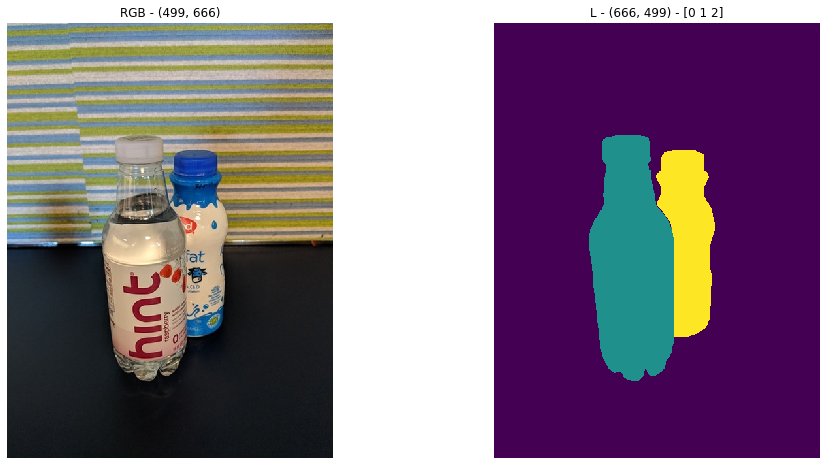

In [5]:
# view the first image
img = Image.open(img_path)
mask = Image.open(mask_path)
mask_np = np.array(mask)
img_label = f'{img.mode} - {img.size}'
mask_label = f'{mask.mode} - {mask_np.shape} - {np.unique(mask_np)}'

show_ims(
    im_paths=[img_path, mask_path],
    labels=[img_label, mask_label],
    size=8
)

In [6]:
# read the annotation of the first image
print(Path(annotation_path).read_text())

<annotation>
	<folder>images</folder>
	<filename>117.jpg</filename>
	<path>../images/117.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>499</width>
		<height>666</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>water_bottle</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>140</xmin>
			<ymin>167</ymin>
			<xmax>279</xmax>
			<ymax>552</ymax>
		</bndbox>
	</object>
	<object>
		<name>milk_bottle</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>240</xmin>
			<ymin>190</ymin>
			<xmax>342</xmax>
			<ymax>487</ymax>
		</bndbox>
	</object>
</annotation>



Putting together the mask and the bounding box, we get:

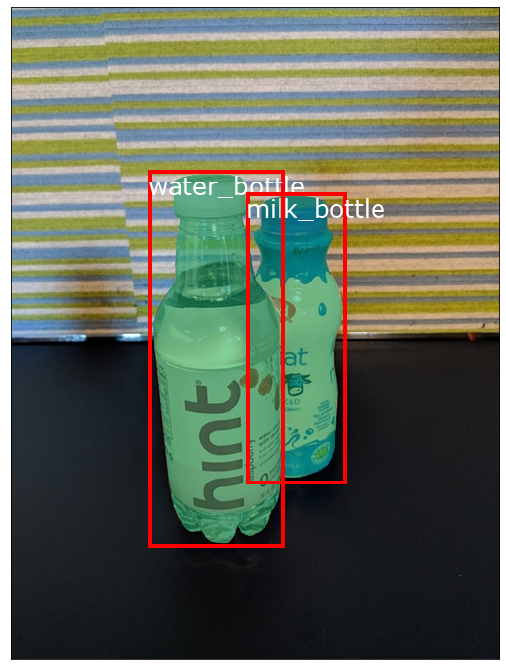

In [7]:
# plot bounding boxes and masks
bboxes, _ = parse_pascal_voc_anno(annotation_path)
display_bbox_mask(bboxes, img_path, mask_path)

## Instance Segmentation with Pretrained Mask R-CNN Model

We will use the pretrained [Mask R-CNN ResNet-50 FPN](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn) in PyTorch for instance segmentation.  As said in [the doc](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn), the model is pretrained on [COCO train2017](http://images.cocodataset.org/zips/train2017.zip) (18GB).  It expects a list of images as `List[Tensor[C, H, W]]` in the range of `0-1` and returns the predictions as `List[Dict[Tensor]]`.  The fields of the `Dict` include `scores`, `labels`, `boxes` and `masks`, each of which is of the same length as the input image list.  The `labels` belong to the 91 categories in the [COCO datasets](http://cocodataset.org/).

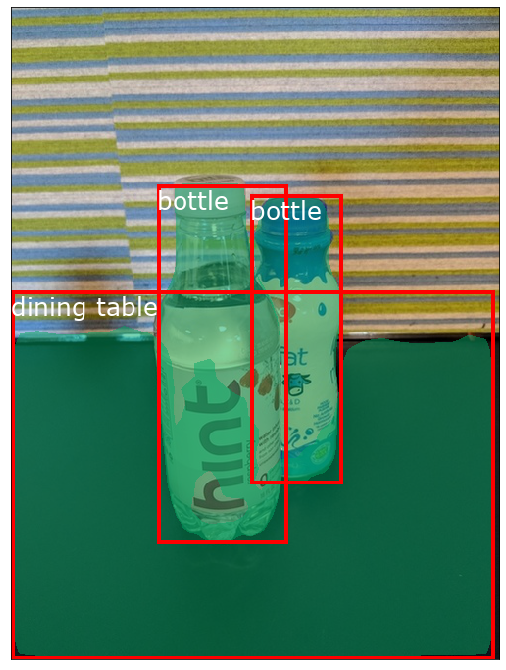

In [8]:
# get pretrained model
detector = DetectionLearner(model=get_pretrained_maskrcnn(), device=device)
# predict
bboxes, binary_masks = detector.predict(img_path, threshold=0.5, mask_threshold=0.5)
# plot
display_bbox_mask(bboxes, img_path, binary_masks)

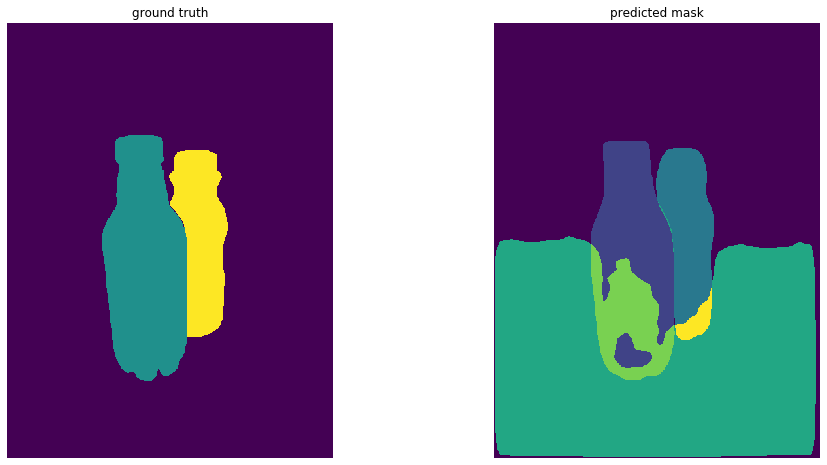

In [9]:
# compare ground truth and predicted mask
show_ims(
    im_paths=[mask_path, merge_binary_masks(binary_masks)],
    labels=['ground truth', 'predicted mask'],
    size=8
)

## Finetuning Mask R-CNN model

Since there are no `milk_bottle` and `water_bottle` in the labels of COCO datasets, we need to fine-tune the pre-trained Mask R-CNN model for odFridgeObjects-mask with the 4 labels.  Follow the practice in our [01_training_introduction notebook](01_training_introduction.ipynb), we need to prepare the `DetectionDataset` to be used by the `DetectionLearner` with a customized Mask R-CNN model.

### Prepare Dataset and Load Images

To load the data, we need to create a Dataset object class that Torchvision knows how to use.  To make it more convinient, we've created a DetectionDataset class that knows how to extract annotation information from the Pascal VOC format or COCO format and meet the requirements of the Torchvision dataset object class.

In [10]:
mask_data = DetectionDataset(root=DATA_PATH, mask_dir='segmentation-objects')
mask_data[0]

(tensor([[[0.7373, 0.7294, 0.7373,  ..., 0.4275, 0.4667, 0.4941],
          [0.7373, 0.7373, 0.7569,  ..., 0.4745, 0.4667, 0.4627],
          [0.6941, 0.6980, 0.7216,  ..., 0.5059, 0.5020, 0.5020],
          ...,
          [0.0588, 0.0627, 0.0745,  ..., 0.0667, 0.0627, 0.0627],
          [0.0627, 0.0667, 0.0706,  ..., 0.0588, 0.0588, 0.0588],
          [0.0627, 0.0667, 0.0706,  ..., 0.0667, 0.0667, 0.0667]],
 
         [[0.7412, 0.7333, 0.7412,  ..., 0.4510, 0.4902, 0.5176],
          [0.7412, 0.7412, 0.7608,  ..., 0.4745, 0.4667, 0.4627],
          [0.7098, 0.7137, 0.7373,  ..., 0.4784, 0.4745, 0.4745],
          ...,
          [0.0784, 0.0824, 0.0941,  ..., 0.0824, 0.0784, 0.0784],
          [0.0824, 0.0863, 0.0902,  ..., 0.0745, 0.0745, 0.0745],
          [0.0824, 0.0863, 0.0902,  ..., 0.0824, 0.0824, 0.0824]],
 
         [[0.7176, 0.7098, 0.7176,  ..., 0.4039, 0.4431, 0.4706],
          [0.7216, 0.7216, 0.7412,  ..., 0.3333, 0.3255, 0.3216],
          [0.7137, 0.7176, 0.7412,  ...,

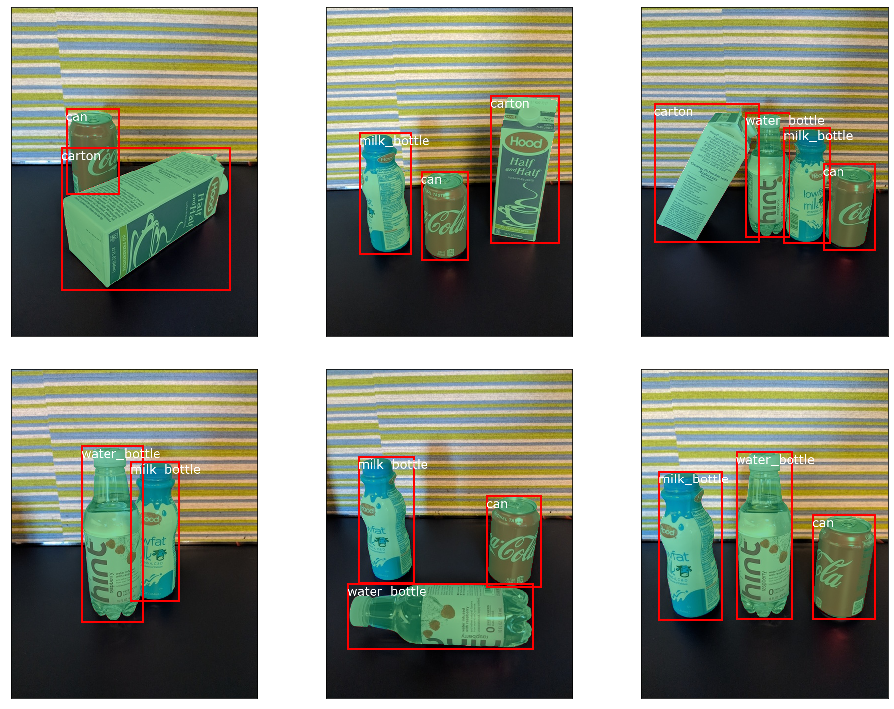

In [11]:
mask_data.show_ims(rows=2, seed=168)

### Re-train

We provide the `get_pretrained_maskrcnn()` function to facilitate the customization of Mask R-CNN model with a ResNet-50-FPN backbone.

In [12]:
# train
detector = DetectionLearner(
    dataset=mask_data, 
    model=get_pretrained_maskrcnn(len(mask_data.labels)+1), 
    device=device)
detector.fit(epochs=10, lr=0.005, print_freq=30)

Epoch: [0]  [0/4]  eta: 0:01:00  lr: 0.001670  loss: 3.4852 (3.4852)  loss_classifier: 1.3626 (1.3626)  loss_box_reg: 0.3652 (0.3652)  loss_mask: 1.7291 (1.7291)  loss_objectness: 0.0134 (0.0134)  loss_rpn_box_reg: 0.0149 (0.0149)  time: 15.1105  data: 0.4506  max mem: 0
Epoch: [0]  [3/4]  eta: 0:00:13  lr: 0.005000  loss: 2.6012 (3.0930)  loss_classifier: 0.8305 (0.9812)  loss_box_reg: 0.2771 (0.3050)  loss_mask: 1.4241 (1.7842)  loss_objectness: 0.0047 (0.0069)  loss_rpn_box_reg: 0.0149 (0.0156)  time: 13.8171  data: 0.1150  max mem: 0
Epoch: [0] Total time: 0:00:55 (13.8542 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:01:03  model_time: 10.1639 (10.1639)  evaluator_time: 0.0025 (0.0025)  time: 12.6493  data: 0.7466  max mem: 0
Test:  [4/5]  eta: 0:00:09  model_time: 9.7042 (8.7852)  evaluator_time: 0.0018 (0.0019)  time: 9.2882  data: 0.1537  max mem: 0
Test: Total time: 0:00:46 (9.3473 s / it)
Averaged stats: model_time: 9.7042 (8.7852)  evaluator_time: 0.0018 (0.0

Epoch: [3]  [0/4]  eta: 0:00:59  lr: 0.005000  loss: 1.0123 (1.0123)  loss_classifier: 0.2081 (0.2081)  loss_box_reg: 0.1921 (0.1921)  loss_mask: 0.5823 (0.5823)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0254 (0.0254)  time: 14.8908  data: 1.1578  max mem: 0
Epoch: [3]  [3/4]  eta: 0:00:13  lr: 0.005000  loss: 0.9560 (0.9712)  loss_classifier: 0.2202 (0.2241)  loss_box_reg: 0.1922 (0.1985)  loss_mask: 0.4996 (0.5190)  loss_objectness: 0.0045 (0.0058)  loss_rpn_box_reg: 0.0254 (0.0238)  time: 13.6418  data: 0.2918  max mem: 0
Epoch: [3] Total time: 0:00:54 (13.7473 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:00:58  model_time: 10.4450 (10.4450)  evaluator_time: 0.1088 (0.1088)  time: 11.6598  data: 1.1057  max mem: 0
Test:  [4/5]  eta: 0:00:09  model_time: 9.9710 (9.0319)  evaluator_time: 0.1088 (0.1003)  time: 9.3564  data: 0.2237  max mem: 0
Test: Total time: 0:00:47 (9.4354 s / it)
Averaged stats: model_time: 9.9710 (9.0319)  evaluator_time: 0.1088 (0.1

Epoch: [6]  [0/4]  eta: 0:01:04  lr: 0.005000  loss: 0.7176 (0.7176)  loss_classifier: 0.2190 (0.2190)  loss_box_reg: 0.2300 (0.2300)  loss_mask: 0.2540 (0.2540)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0136 (0.0136)  time: 16.0223  data: 1.2313  max mem: 0
Epoch: [6]  [3/4]  eta: 0:00:14  lr: 0.005000  loss: 0.7176 (0.8364)  loss_classifier: 0.2050 (0.2128)  loss_box_reg: 0.2108 (0.2231)  loss_mask: 0.2843 (0.3801)  loss_objectness: 0.0027 (0.0026)  loss_rpn_box_reg: 0.0145 (0.0177)  time: 14.6637  data: 0.3106  max mem: 0
Epoch: [6] Total time: 0:00:59 (14.7964 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:01:01  model_time: 10.9879 (10.9879)  evaluator_time: 0.1407 (0.1407)  time: 12.3143  data: 1.1854  max mem: 0
Test:  [4/5]  eta: 0:00:10  model_time: 10.9879 (9.8316)  evaluator_time: 0.1307 (0.1199)  time: 10.1913  data: 0.2387  max mem: 0
Test: Total time: 0:00:51 (10.2797 s / it)
Averaged stats: model_time: 10.9879 (9.8316)  evaluator_time: 0.1307 

Epoch: [9]  [0/4]  eta: 0:01:08  lr: 0.000500  loss: 1.0784 (1.0784)  loss_classifier: 0.2729 (0.2729)  loss_box_reg: 0.3045 (0.3045)  loss_mask: 0.4845 (0.4845)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0154 (0.0154)  time: 17.1711  data: 1.4117  max mem: 0
Epoch: [9]  [3/4]  eta: 0:00:14  lr: 0.000500  loss: 0.7859 (0.8012)  loss_classifier: 0.1926 (0.2185)  loss_box_reg: 0.2134 (0.2362)  loss_mask: 0.2522 (0.3300)  loss_objectness: 0.0006 (0.0010)  loss_rpn_box_reg: 0.0140 (0.0155)  time: 14.7632  data: 0.3541  max mem: 0
Epoch: [9] Total time: 0:00:59 (14.9013 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:01:01  model_time: 10.8938 (10.8938)  evaluator_time: 0.1326 (0.1326)  time: 12.3326  data: 1.3058  max mem: 0
Test:  [4/5]  eta: 0:00:10  model_time: 10.8938 (9.6383)  evaluator_time: 0.1196 (0.1107)  time: 10.0144  data: 0.2636  max mem: 0
Test: Total time: 0:00:50 (10.1108 s / it)
Averaged stats: model_time: 10.8938 (9.6383)  evaluator_time: 0.1196 

Visualize the loss and average precision (ap) over time.

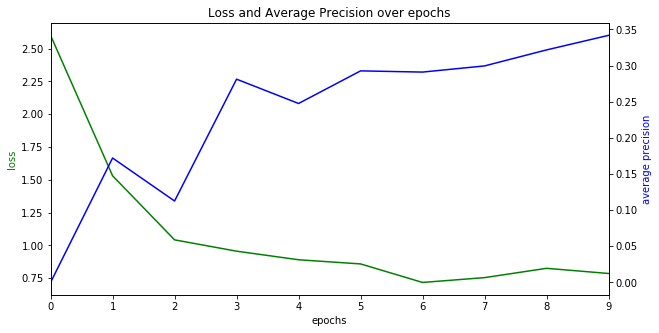

In [13]:
detector.plot_precision_loss_curves()

### Predict Single Image

1


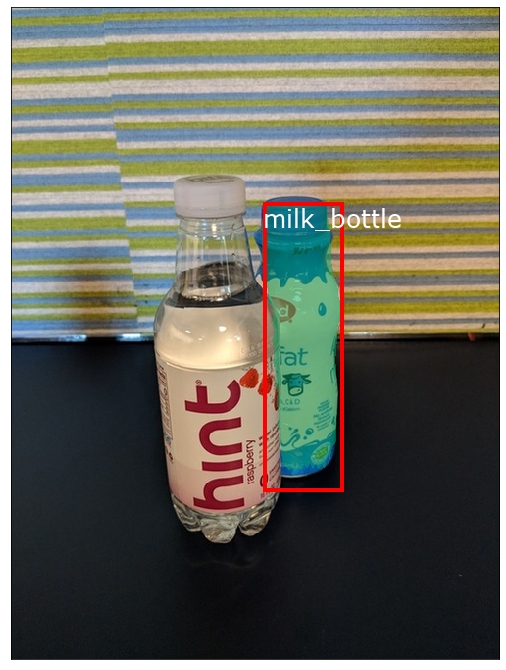

In [17]:
# predict
bboxes, binary_masks = detector.predict(mask_data.im_paths[0], threshold=0.5, mask_threshold=0.5)
print(len(bboxes))
# plot
display_bbox_mask(bboxes, mask_data.im_paths[0], binary_masks)

Because there are only 16 images annotated with masks, this result is not ideal.

## Keypoint R-CNN

Keypoints of an object are predefined points that are useful for describing the object.  For example, facial or body keypoint detection can be used for emotion and pose recognition.  Here we just demostrate how to do human body keypoints detection using the pretrained Keypoint R-CNN model in PyTorch.  The Keypoint R-CNN model in PyTorh during inference will return for each image a `Dict[Tensor]` contains `boxes`, `labels`, `scores` and `keypoints`.  The pretrained model is built on the [COCO train2017 dataset (118K/18GB)](http://images.cocodataset.org/zips/train2017.zip) with 17 annotated human body keypoints.

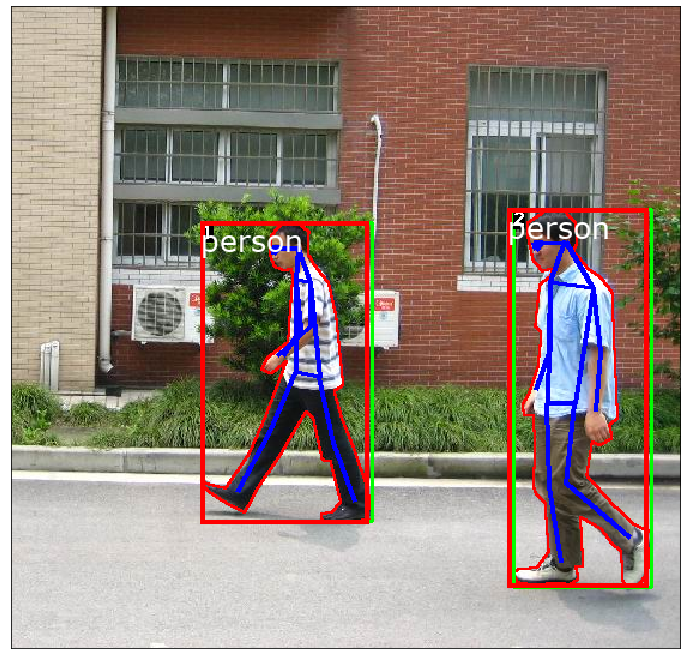

In [21]:
# download image
import urllib.request
from utils_cv.common.data import data_path
img_url = "https://www.cis.upenn.edu/~jshi/ped_html/images/FudanPed00001_1.png"
img_path = data_path() / img_url.split('/')[-1]
urllib.request.urlretrieve(img_url, img_path)
# predict
detector = DetectionLearner(model=get_pretrained_keypointrcnn(), device=device)
bboxes, keypoints = detector.predict(img_path, threshold=0.5)
# plot
display_bbox_mask_keypoint(bboxes, img_path, None, keypoints)

## Conclusion

In this notebook, we demonstrate how to use the concepts in our [01_training_introduction notebook](01_training_introduction.ipynb) to prepare an Mask R-CNN model detector fine-tuned on your own dataset for instance segmentation.  We also introduce how to do human body keypoints detection.